# About
Replication of Chapter 10 plots of S&P500 returns.

In [1]:
import numpy as np
import pandas as pd



# Helper Function

In [2]:
def get_SP500_daily_returns(data_source, log_returns=False):
    """Load time series of SP500 daily returns from finance.yahoo.com
    
    Parameters
    ----------
    data_source : str
        URL or path to csv file.
    log_returns : bool
        False returns the return ratio minus one.
            e.g. 0.20 for a 20% gain, -0.80 for a 20% decline.
        True returns the natural log of the return ratio.

    
    Returns
    -------
    daily_return : Pandas Series
    """

    # Load Dataset
    price_data = pd.read_csv(data_source, index_col=0, parse_dates=True)
    
    # Select Closing Prices
    close_price = price_data.Close
    
    # Calculate Daily Return
    price_change_ratio = close_price / close_price.shift(1) 

    if log_returns:
        daily_return = np.log(price_change_ratio)
    else:
        daily_return = price_change_ratio - 1
    
    # Remove NaN value
    ## The first day has no prior day so return is NaN
    assert daily_return.isna().sum() == 1  
    daily_return.dropna(inplace=True)

    return daily_return

# Fetch S&P 500 Returns

Calculate the historic daily returns. For context, a value of 0.01 indicates a 1% increase in value on the specified day.

In [3]:
# Calculate Returns
# This particular link captures 60 years from 1960 to 2019 end.
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-315619200&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'

In [4]:
daily_returns = get_SP500_daily_returns(data_source)
daily_returns

Date
1960-01-05    0.008012
1960-01-06   -0.004305
1960-01-07   -0.007318
1960-01-08   -0.003183
1960-01-11   -0.012269
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: Close, Length: 15101, dtype: float64

In [5]:
log_returns = get_SP500_daily_returns(data_source, log_returns=True)
log_returns

Date
1960-01-05    0.007980
1960-01-06   -0.004315
1960-01-07   -0.007344
1960-01-08   -0.003188
1960-01-11   -0.012345
                ...   
2019-12-24   -0.000195
2019-12-26    0.005115
2019-12-27    0.000034
2019-12-30   -0.005798
2019-12-31    0.002942
Name: Close, Length: 15101, dtype: float64

In [6]:
# Save data to file
#daily_returns.to_csv('NB37_daily_returns.csv')

# Figure 10.1 Log-Log Survival Probability

In [7]:
import fattails

In [8]:
sr = 100*daily_returns.abs()

In [9]:
sr.rename('daily_return', inplace=True)
df = sr.to_frame()

In [10]:
# Calculate survival probability for each datapoint
df['survival_probability'] = fattails.metrics.get_survival_probability(df.daily_return)
df = df.sort_values(by='daily_return') # show sorted values
df

,daily_return,survival_probability
Date,,
1960-07-19,0.000000,0.999934
1979-08-29,0.000000,0.999868
1976-04-29,0.000000,0.999801
1976-03-26,0.000000,0.999735
1985-03-28,0.000000,0.999669
...,...,...
2008-10-15,9.034978,0.000331
1987-10-21,9.099355,0.000265
2008-10-28,10.789006,0.000199


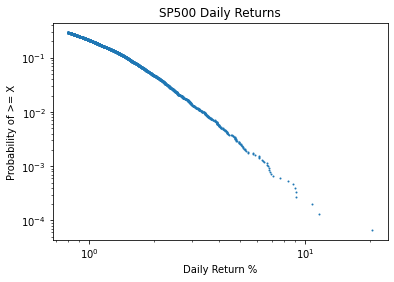

In [11]:
# Plot the Right Tail
selection = df.daily_return > 0.8 

right_tail = df.loc[selection]

right_tail.plot(x='daily_return', y='survival_probability',
                xlabel='Daily Return %', ylabel='Probability of >= X', 
                title='SP500 Daily Returns',
                kind='scatter', loglog=True,
                s=1); # xlabel argument requires pandas >= 1.2.0

# Figure 10.2 Convergence of Kurtosis
Kurtosis is a proxy for fat-tailedness.

In [12]:
df = log_returns.rename('log_return').to_frame()
df

,log_return
Date,
1960-01-05,0.007980
1960-01-06,-0.004315
1960-01-07,-0.007344
1960-01-08,-0.003188
1960-01-11,-0.012345
...,...
2019-12-24,-0.000195
2019-12-26,0.005115
2019-12-27,0.000034


In [13]:
kurtosis_df = pd.DataFrame({'window_size':range(1,100+1)})
kurtosis_df.head()

,window_size
0,1
1,2
2,3
3,4
4,5


In [14]:
from scipy.stats import kurtosis

def grouped_kurtosis(df, window_size):
    """ Calculate the kurtosis of log returns for different lags."""

    df = df.copy()

    df['window_number'] = np.arange(0, len(df)) // window_size

    kurt = df.groupby(df.window_number).sum().apply(kurtosis, fisher=False)
    
    return kurt

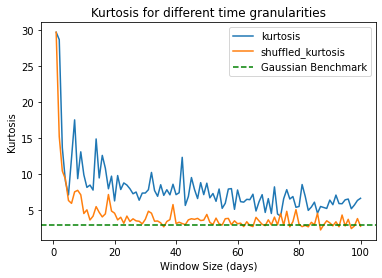

In [15]:
kurtosis_df['kurtosis'] = kurtosis_df.window_size.apply(lambda window_size: grouped_kurtosis(df, window_size))

kurtosis_df['shuffled_kurtosis'] = kurtosis_df.window_size.apply(lambda window_size: grouped_kurtosis(df.sample(frac=1), window_size))

trace_columns = ['kurtosis', 'shuffled_kurtosis']

ax = kurtosis_df.plot(x='window_size', y=trace_columns,
                  xlabel='Window Size (days)', ylabel='Kurtosis',
                  title='Kurtosis for different time granularities');

ax.axhline(3, color='g', linestyle='--', label='Gaussian Benchmark');

ax.legend();